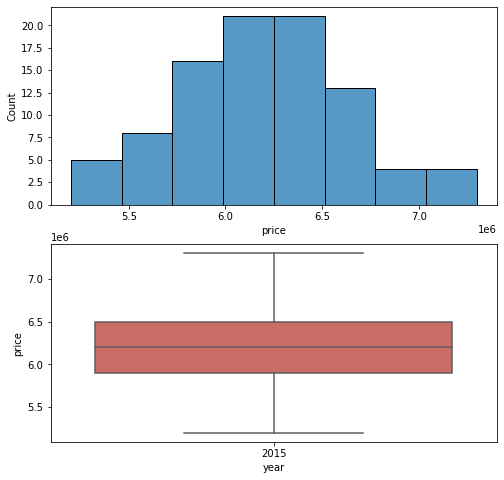

       count          mean            std        min        25%        50%  \
year    92.0  2.015000e+03       0.000000     2015.0     2015.0     2015.0   
price   92.0  6.184302e+06  457230.533051  5200000.0  5897500.0  6200000.0   

             75%        max  
year      2015.0     2015.0  
price  6500000.0  7300000.0  


In [44]:
import requests
from bs4 import BeautifulSoup
import time
from itertools import groupby
import os
import random
import json
import datetime
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unicodedata
def get_url(url,save_path):
    result=[]
    count=0
    response=requests.get(url)
    soup=BeautifulSoup(response.text,'lxml')   
    try:
        pages=int(soup.find('div',class_='pager').find_all('li')[-1].text.strip())
    except:
        pages=1
    for page in range(1,pages+1):   
        response2=requests.get(f'{url}&page={page}')
        soup2=BeautifulSoup(response2.text,'lxml')        
        links=soup2.find_all('div',attrs={'class': lambda e: e.startswith('row vw-item list-item') if e else False})
        for link in links:
            result.append({'link':str('https://kolesa.kz')+str(link.find('a',class_='list-link').get('href'))})
        count+=1        
        print(f'Done: {count}'+f'/{pages}',end='\r')      
    with open(f'{save_path}/main_links.json','w',encoding='utf-8') as file:
        json.dump(result,file,indent=4,ensure_ascii=False)         
def get_data(path):
    data = json.load(open(path,'r', encoding='utf-8'))
    result=[]
    count=0
    for item in data:
        parameters=[]
        response=requests.get(item.get('link'))
        soup=BeautifulSoup(response.text,'lxml')
        title=soup.find('h1',class_='offer__title').text.strip()
        price=soup.find('div',class_='offer__price').text.strip().split('₸')[0].strip()
        year=int(soup.find('h1',class_='offer__title').find('span',class_='year').text.strip())
        headings=soup.find('div',class_='offer__parameters').find_all('dt',class_='value-title')
        values=soup.find('div',class_='offer__parameters').find_all('dd',class_='value')
        for i in range(len(headings)):
            parameters.append({
                f'{headings[i].text.strip()}':f'{values[i].text.strip()}'             
            })        
        result.append({
            'title':title,
            'year':year,
            'price':price,
            'parameters':parameters,
            'link':item.get('link')
        })
        
        count+=1        
        print(f'Done: {count}'+f'/{len(data)}',end='\r')
    save_path='/'.join(path.split('\\')[:-1])
    with open(f'{save_path}\\result.json','w',encoding='utf-8') as file:
        json.dump(result,file,indent=4,ensure_ascii=False)        
def convert_to_excel(path):
    data = json.load(open(path,'r', encoding='utf-8'))
    data=pd.json_normalize(data)
    for i in range(len(data)):
        b=data.parameters[i]
        for j in b:
            if j.get('Город') !=None:
                data.at[i,'Город']=j.get('Город')
            elif j.get('Коробка передач')!=None:
                data.at[i,'Коробка передач']=j.get('Коробка передач')
            elif j.get('Кузов')!=None:
                data.at[i,'Кузов']=j.get('Кузов')
            elif j.get('Объем двигателя, л')!=None:
                data.at[i,'Объем двигателя, л']=j.get('Объем двигателя, л')    
            elif j.get('Пробег')!=None:
                data.at[i,'Пробег']=j.get('Пробег') 
            elif j.get('Привод')!=None:
                data.at[i,'Привод']=j.get('Привод')
            elif j.get('Руль')!=None:
                data.at[i,'Руль']=j.get('Руль')
            elif j.get('Цвет')!=None:
                data.at[i,'Цвет']=j.get('Цвет')
            elif j.get('Аварийная/Не на ходу')!=None:
                data.at[i,'Аварийная/Не на ходу']=j.get('Аварийная/Не на ходу')
            elif j.get('Растаможен в Казахстане')!=None:
                data.at[i,'Растаможен в Казахстане']=j.get('Растаможен в Казахстане')
    data=data[data['Растаможен в Казахстане']=='Да']
    name=data.title[0].split(' ')[0]
    data['price']=data['price'].apply(lambda x: unicodedata.normalize("NFKD", x))
    data.price=data.price.str.replace(' ','').astype(int)
    data.sort_values(by=['price'],ascending=False,inplace=True)
    save_path='/'.join(path.split('\\')[:-1])
    data.to_excel(f'{save_path}\\{name}.xlsx',index=False) 
def plot(file_path):
    df=pd.read_excel(file_path)
    df=df[df['Коробка передач']=='автомат']
    fig, axes = plt.subplots(2, 1)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    sns.histplot(data=df, x='price', ax=axes[0],palette='hls')
    sns.boxplot(y=df['price'],x='year',data=df, ax=axes[1],palette='hls')
    plt.show()
    print(df.describe().T)
    
def main():
    city='almaty'         #almaty,taraz
    model='hyundai'
    marka='accent'
    year_from=2015
    year_to=2015
    url=f'https://kolesa.kz/cars/{model}/{marka}/{city}/?year[from]={year_from}&year[to]={year_to}' 
    save_path=r'C:\Users\svnduw\Desktop\Bekbol\Bekbol project\koleso' #path must be changed     
    get_url(url,save_path)     
    get_data(f'{save_path}\\main_links.json')
    convert_to_excel(f'{save_path}\\result.json')
    plot(f'{save_path}//Hyundai.xlsx')
if __name__=="__main__":
     main() 